# Data Preprocessing

## Getting the dataset

Dependencies

In [4]:
import kagglehub
import shutil
import pandas as pd
import numpy as np
import os

c:\Users\Bruno Hime\OneDrive\Documentos\Bruno\Pessoal\codes\bravium\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kaggle dataset

In [5]:
# Download (goes to cache)
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

# Current working directory
cwd = os.getcwd()

# Copy all files to current folder
for file in os.listdir(path):
    shutil.copy(os.path.join(path, file), cwd)

print("Files copied to:", cwd)
print("Now you have:", os.listdir(cwd))


Files copied to: c:\Users\Bruno Hime\OneDrive\Documentos\Bruno\Pessoal\codes\bravium
Now you have: ['main.ipynb', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'README.md', 'requirements.txt', 'venv']


In [6]:
# Display all columns and full content in DataFrames

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

Datasets

In [7]:
# Datasets that will not be used for the model

# customers_df = pd.read_csv("olist_customers_dataset.csv") # information about the customer id and its location
# geolocations_df = pd.read_csv("olist_geolocation_dataset.csv") # Brazilian zip codes and its lat/lng coordinates
# sellers_df = pd.read_csv("olist_sellers_dataset.csv") # Information about the sellers (e.g. location)
# product_category_name_translation_df = pd.read_csv("product_category_name_translation.csv") # English translation of the product category names
# order_payments_df = pd.read_csv("olist_order_payments_dataset.csv") # orders payment options (e.g. credit card, number of installments and value)

# Selected datasets for the model
order_items_df = pd.read_csv("olist_order_items_dataset.csv") # includes data about the items purchased within each order
order_reviews_df = pd.read_csv("olist_order_reviews_dataset.csv") # includes data about the reviews made by the customers
orders_df = pd.read_csv("olist_orders_dataset.csv") # Order status (delivered, shipped, etc) and purchase timestamp
products_df = pd.read_csv("olist_products_dataset.csv") # informations about the products (e.g. name, category and number of photos and legth description)


## Dataset Creation

#### Objective

To build a classification model that predicts whether a product will receive a positive or negative review. The dataset will be structured with each row representing a unique product purchase.

#### Problem Analysis
Our dataset contains diverse information about e-commerce transactions, including:
- Customer information and location
- Seller details
- Payment methods
- Order items and status
- Customer reviews

To predict review sentiment, we'll create features that capture key aspects affecting customer satisfaction:

#### Feature Set

| Feature | Description | Rationale |
|---------|-------------|-----------|
| `delivery_time` | Time taken to deliver the order | Delivery speed impacts satisfaction |
| `delivery_delay` | Difference between estimated and actual delivery date | Late/early deliveries affect reviews |
| `review_score` | Customer rating (1-5) | Target variable |
| `combined_text` | Concatenated review comments | Textual feedback from customers |
| `price` | Product price | Value perception |
| `freight_value` | Shipping cost | Additional cost impact |
| `product_category_name` | Product category | Different expectations per category |
| `product_description_length` | Length of product description | Indicator of information quality |
| `product_photos_qty` | Number of product photos | Visual information quality |
| `seller_historical_score` | Seller's average rating over time | Seller reliability |
| `seller_total_sales` | Number of seller's past sales | Seller experience |

The combination of these features will help predict customer satisfaction levels and identify factors that most strongly influence review scores.

#### Orders Data Processing

The `orders_df` is the core dataset. From each order you might find all other information. So it will be the starting point to create all the desired columns

In [8]:
clean_orders_df = orders_df.drop_duplicates(subset='order_id') \
                           .dropna(subset=['order_id'])

clean_orders_df.describe(include="all")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-08-02 12:05:26,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 19:36:48,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


##### Organizing the time columns

Columns that will be created in this part:

- `delivery_time`: Number of days between order placement and actual delivery
- `delivery_delay`: Difference between estimated and actual delivery dates

**Calculation Method**

1. `delivery_time`
   - Start: `order_purchase_timestamp` (when customer placed the order)
   - End: `order_delivered_customer_date` (when customer received the order)
   - Calculation: `End - Start` in days

2. `delivery_delay`
   - Expected: `order_estimated_delivery_date`
   - Actual: `order_delivered_customer_date`
   - Calculation: `Actual - Expected` in days
   - Interpretation:
     - Negative value: Early delivery
     - Zero: On-time delivery
     - Positive value: Late delivery

In [ ]:
timestamp_columns = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date",
                     "order_delivered_customer_date", "order_estimated_delivery_date"]

# Transforming columns to datetime format
timestamp_df = clean_orders_df[timestamp_columns].apply(pd.to_datetime, errors='coerce')

In [ ]:
# Creating the delivery_time column
timestamp_df["delivery_time"] = (timestamp_df["order_delivered_customer_date"] - timestamp_df["order_purchase_timestamp"]).dt.days

# Creating the delivery_delay column
timestamp_df["delivery_delay"] = (timestamp_df["order_delivered_customer_date"] - timestamp_df["order_estimated_delivery_date"]).dt.days

# Removing the original timestamp columns from clean_orders_df
clean_orders_df.drop(columns=timestamp_columns, inplace=True)

# Joining the new columns to clean_orders_df
# order_delivered_customer_date was included because it will be used in future analysis
clean_orders_df = pd.concat([clean_orders_df, timestamp_df[["delivery_time", "delivery_delay",
                                                             "order_purchase_timestamp"]]], axis=1)
clean_orders_df.head()

,order_id,customer_id,order_status,delivery_time,delivery_delay,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,8.0,-8.0,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,13.0,-6.0,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,9.0,-18.0,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,13.0,-13.0,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2.0,-10.0,2018-02-13 21:18:39


#### Reviews Data Processing

Columns that will be created in this part:
- `review_score`: Customer rating on a 1-5 scale
- `combined_text`: Merged review title and message content

**Data Cleaning Steps**

1. `review_id` Processing
   - Remove duplicate review IDs
   - Drop entries with null review IDs

2. `review_text` Processing
   - Combine review title and message
   - Clean empty values
   - Join multiple reviews for same order

**Important Notes**
- Not all orders have associated reviews
- Reviews are linked to orders, not individual products
- Some orders may have multiple reviews

In [ ]:
# Removing duplicates and NaN reviews_id
clean_order_reviews_df = order_reviews_df.drop_duplicates(subset='review_id') \
                                          .dropna(subset=['review_id']) \
                                          .drop(columns=['review_creation_date', 'review_answer_timestamp'])
clean_order_reviews_df.describe(include="all")

,review_id,order_id,review_score,review_comment_title,review_comment_message
count,98410,98410,98410.000000,11519,40668
unique,98410,98167,NaN,4527,36159
top,efe49f1d6f951dd88b51e6ccd4cc548f,0ee24d5ae95ccf0552a2ef03dfadb924,NaN,Recomendo,Muito bom
freq,1,2,NaN,422,229
mean,NaN,NaN,4.088802,NaN,NaN
std,NaN,NaN,1.345758,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN


In [ ]:
# Combine title and comment
clean_order_reviews_df['combined_text'] = clean_order_reviews_df['review_comment_title'].fillna('') + '\n' + clean_order_reviews_df['review_comment_message'].fillna('')
clean_order_reviews_df['combined_text'] = clean_order_reviews_df['combined_text'].str.strip()

# Group by order_id and aggregate
grouped_reviews = clean_order_reviews_df.groupby('order_id').agg({
    'review_score': 'mean',
    'combined_text': lambda x: ' | '.join(x[x != ''])  # Join non-empty texts with |
}).reset_index()

grouped_reviews.head()

,order_id,review_score,combined_text
0,00010242fe8c5a6d1ba2dd792cb16214,5.0,"Perfeito, produto entregue antes do combinado."
1,00018f77f2f0320c557190d7a144bdd3,4.0,
2,000229ec398224ef6ca0657da4fc703e,5.0,Chegou antes do prazo previsto e o produto surpreendeu pela qualidade. Muito satisfatório.
3,00024acbcdf0a6daa1e931b038114c75,4.0,
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0,Gostei pois veio no prazo determinado .


Combining everything with the `clean_orders_df`

In [ ]:
# Merge clean_orders_df with grouped_reviews
merged_review_df = clean_orders_df.merge(
    grouped_reviews,
    on='order_id',
    how='left'  # Keep all orders, even those without reviews
)

##### Analysis of Review Dataset Structure

Customer reviews in this dataset are linked to orders rather than specific products, representing the overall purchase experience. This structure requires careful consideration for our analysis.

**Key Findings:**

1. **Multiple Products per Order**
   - Approximately **9.94%** of orders contain multiple products
   - Impacts how we interpret review scores for individual products

2. **Review Distribution**
   - **243 orders** have multiple reviews registered
   - Which required aggregation strategy

**Conclusion:**  
Although the reviews are given at the order level, it is a reasonable approximation to represent the dataset with one row per product, using the order’s review as its label.

In [14]:
# Get orders with multiple products and their reviews
multiple_products = order_items_df.groupby('order_id').size()
multiple_products_orders = multiple_products[multiple_products > 1]
orders_with_reviews = clean_order_reviews_df['order_id'].unique()

# Basic statistics about multiple products
print(f"Total orders with multiple products: {len(multiple_products_orders)}")
print(f"Percentage of orders with multiple products: {(len(multiple_products_orders) / len(order_items_df['order_id'].unique()) * 100):.2f}%")

# Analyze reviews per order
reviews_per_order = clean_order_reviews_df.groupby('order_id').size().reset_index(name='review_count')
multiple_reviews = reviews_per_order[reviews_per_order['review_count'] > 1]

# Print summary of multiple reviews
print(f"\nOrders with multiple reviews: {len(multiple_reviews)}")

Total orders with multiple products: 9803
Percentage of orders with multiple products: 9.94%

Orders with multiple reviews: 243


#### Price and Shipping Data Processing

Columns that will be created in this part:
- `price`: Product unit price
- `freight_value`: Shipping cost per item

**Data Processing Steps:**
1. Merge `order_items_df` with our current dataset
2. Preserve all existing orders (left join)
3. Showing a sample case of an order with multiple items

In [15]:
# Merge order_items_df with merged_review_df keeping only the merged_review_df's order_id
merged_items_df = merged_review_df.merge(
    order_items_df,
    on='order_id',
    how='left'
)

# Display some statistics about the merge
print("Original shapes:")
print(f"order_items_df: {order_items_df.shape}")
print(f"merged_review_df: {merged_review_df.shape}")
print(f"Final shape: {merged_items_df.shape}")

print("\nSample of orders with multiple items:")
merged_items_df[merged_items_df["order_id"] == "acce194856392f074dbf9dada14d8d82"]

Original shapes:
order_items_df: (112650, 7)
merged_review_df: (99441, 8)
Final shape: (113425, 14)

Sample of orders with multiple items:


,order_id,customer_id,order_status,delivery_time,delivery_delay,order_purchase_timestamp,review_score,combined_text,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
27,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,delivered,12.0,-32.0,2018-06-04 00:00:13,1.0,"NÃO RECOMENDO!!!! \nAté o momento não recebi o produto Protetor De Colchão Para Berço - Algodão Impermeável, já fiz a reclamação desde o dia 18/06 e ainda não obtive retorno. Irei cancelar o pedido e estornar a compra hj",1.0,d70f38e7f79c630f8ea00c993897042c,977f9f63dd360c2a32ece2f93ad6d306,2018-06-13 00:35:10,90.9,48.64
28,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,delivered,12.0,-32.0,2018-06-04 00:00:13,1.0,"NÃO RECOMENDO!!!! \nAté o momento não recebi o produto Protetor De Colchão Para Berço - Algodão Impermeável, já fiz a reclamação desde o dia 18/06 e ainda não obtive retorno. Irei cancelar o pedido e estornar a compra hj",2.0,9451e630d725c4bb7a5a206b48b99486,d673a59aac7a70d8b01e6902bf090a11,2018-06-13 00:35:10,39.5,48.64


For visualization purposes, same order id from the review dataset

In [16]:
merged_review_df[merged_review_df["order_id"] == "acce194856392f074dbf9dada14d8d82"]

,order_id,customer_id,order_status,delivery_time,delivery_delay,order_purchase_timestamp,review_score,combined_text
26,acce194856392f074dbf9dada14d8d82,7e20bf5ca92da68200643bda76c504c6,delivered,12.0,-32.0,2018-06-04 00:00:13,1.0,"NÃO RECOMENDO!!!! \nAté o momento não recebi o produto Protetor De Colchão Para Berço - Algodão Impermeável, já fiz a reclamação desde o dia 18/06 e ainda não obtive retorno. Irei cancelar o pedido e estornar a compra hj"


For visualization purposes, same order id from the items dataset

In [17]:
order_items_df[order_items_df["order_id"] == "acce194856392f074dbf9dada14d8d82"]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
75893,acce194856392f074dbf9dada14d8d82,1,d70f38e7f79c630f8ea00c993897042c,977f9f63dd360c2a32ece2f93ad6d306,2018-06-13 00:35:10,90.9,48.64
75894,acce194856392f074dbf9dada14d8d82,2,9451e630d725c4bb7a5a206b48b99486,d673a59aac7a70d8b01e6902bf090a11,2018-06-13 00:35:10,39.5,48.64


#### Product Information Data Processing

Columns that will be created in this part:
- `product_category_name`: Product category for market segmentation
- `product_description_length`: Length of product description text
- `product_photos_qty`: Number of product photos

**Data Processing:**
- Source: `products_df`
- Join Type: Left merge on `product_id`

In [18]:
products_df.describe(include='all')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,106392145fca363410d287a815be6de4,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


In [ ]:
# Merging product information by product_id
merged_products_df = merged_items_df.merge(
    products_df[["product_id", "product_category_name", "product_description_lenght", "product_photos_qty"]],
    on='product_id',
    how='left'
)

# product_description_lenght has a typo in the original dataset

#### Seller Data Processing  


**Columns created in this step:**  
- `seller_historical_score`  
- `seller_total_sales`  

In this part, the average score and total sales for each seller will be calculated considering only the products they had already sold **before the given order date** (`order_purchase_timestamp`).  

This approach is necessary to avoid **temporal leakage**: we cannot include ratings from sales that occurred after the purchase date, since those scores were not yet available to the consumer at the time of purchase. Instead, we need to reflect the seller’s perceived quality at the actual moment of the transaction.  

**Note:** For the first occurrence of a given seller (i.e., when no historical data exists), a default average score of **3** will be assigned.  

In [20]:
# Sort by timestamp to ensure chronological order
merged_seller_df = merged_products_df.sort_values('order_purchase_timestamp')

# Function to calculate historical average excluding current row
def get_historical_seller_avg(group):
    # Create array of scores excluding current row (using shift)
    historical_scores = group['review_score'].expanding().mean().shift(1)
    # Fill first occurrence with 3
    return historical_scores.fillna(3)

# Function to calculate number of previous sales
def get_historical_sales_count(group):
    # Count number of previous sales (excluding current row)
    return range(len(group))

# Calculate historical metrics by seller
merged_seller_df['seller_historical_score'] = merged_seller_df.groupby('seller_id').apply(
    get_historical_seller_avg
).reset_index(level=0, drop=True)

merged_seller_df['seller_total_sales'] = merged_seller_df.groupby('seller_id').cumcount()

# Verify results
print("Sample of results:")
sample_seller = merged_seller_df['seller_id'].iloc[0]
sample_data = merged_seller_df[merged_seller_df['seller_id'] == sample_seller].sort_values('order_purchase_timestamp')[
    ['seller_id', 'order_purchase_timestamp', 'review_score', 
     'seller_historical_score', 'seller_total_sales']
].head(5)
sample_data

Sample of results:


C:\Users\Bruno Hime\AppData\Local\Temp\ipykernel_31780\3895759150.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_seller_df['seller_historical_score'] = merged_seller_df.groupby('seller_id').apply(


,seller_id,order_purchase_timestamp,review_score,seller_historical_score,seller_total_sales
5117,1554a68530182680ad5c8b042c3ab563,2016-09-04 21:15:19,1.0,3.000000,0.0
5116,1554a68530182680ad5c8b042c3ab563,2016-09-04 21:15:19,1.0,1.000000,1.0
96497,1554a68530182680ad5c8b042c3ab563,2016-10-04 14:23:50,5.0,1.000000,2.0
43519,1554a68530182680ad5c8b042c3ab563,2016-10-04 15:12:18,5.0,2.333333,3.0
44338,1554a68530182680ad5c8b042c3ab563,2016-10-06 22:23:25,4.0,3.000000,4.0


#### Final Data Processing

Evaluating the viability of removing NaN values

In [21]:
# Current number of rows
total = merged_seller_df.shape[0]

# Removing rows with NaN values and unnecessary columns
final_df = merged_seller_df.dropna().drop(columns=[
    "order_id", "customer_id", "order_status",
    "order_item_id", "product_id", "seller_id", "shipping_limit_date"
])

print(f"Removed rows with NaN values, retaining {final_df.shape[0] / total * 100:.2f}% of the original dataset. Currently at {final_df.shape[0]} rows.")

Removed rows with NaN values, retaining 94.61% of the original dataset. Currently at 107316 rows.


Since we still have 107316 rows, it is a safe number to train our model

In [22]:
final_df.head(3)

,delivery_time,delivery_delay,order_purchase_timestamp,review_score,combined_text,price,freight_value,product_category_name,product_description_lenght,product_photos_qty,seller_historical_score,seller_total_sales
35039,54.0,36.0,2016-09-15 12:16:38,1.0,nao recebi o produto e nem resposta da empresa,44.99,2.83,beleza_saude,1036.0,1.0,3.0,0.0
35037,54.0,36.0,2016-09-15 12:16:38,1.0,nao recebi o produto e nem resposta da empresa,44.99,2.83,beleza_saude,1036.0,1.0,1.0,1.0
35038,54.0,36.0,2016-09-15 12:16:38,1.0,nao recebi o produto e nem resposta da empresa,44.99,2.83,beleza_saude,1036.0,1.0,1.0,2.0


# Target variable creation

To train our model, we need to define a suitable target variable. The two most logical candidates are the **review score** and the **text review**. Each option comes with advantages and trade-offs:

- **Using the text review:**  
  Provides a clearer understanding of customer sentiment and captures more nuanced opinions.  
  However, it requires a robust and scalable mapping strategy to classify sentiments into positive and negative categories.

- **Using the score:**  
  Offers straightforward access and direct mapping to sentiment classes.  
  The drawback is the ambiguity of mid-range values, such as *3*, which may represent neutral or mixed opinions.

### Strategic Choice
Only **56% of the dataset includes text reviews**, which would significantly reduce the training set if used exclusively. In contrast, the **score** is available for the vast majority of records, providing broader coverage.  

Therefore, we will use the **review score** as our primary target variable while incorporating the **text review** as an additional feature during training.

In [23]:
print(final_df[final_df["combined_text"] == ""].shape[0] / final_df.shape[0])
print(final_df[final_df["review_score"].isna()].shape[0] / final_df.shape[0])

0.5630008572813001
0.0


Review score distribution

In [24]:
final_df["review_score"].value_counts().sort_index(ascending=False)

review_score
5.0    61824
4.5       26
4.0    20688
3.5       14
3.0     9038
2.5       18
2.0     3585
1.5       11
1.0    12112
Name: count, dtype: int64

 To reduce ambiguity and make the model more precise, we will map only the **safe scores**:

| Review Score | Sentiment |
|--------------|-----------|
| 1–2          | Negative  |
| 4–5          | Positive  |
| 2-4            | Holdout (to be analyzed later) |

By excluding the mid-range scores (2-4) during the initial training phase, we avoid uncertainty and ensure a clearer separation between positive and negative classes.

We can see that removing the ambiguous score, we still have **91.55% of the dataset** to be trained, witch is a good number

Once the base model is stable, we will revisit this holdout dataset reviews to analyze and classify them.

In [25]:
review_score = final_df[["review_score", "combined_text"]].copy()

# Mapping review scores to binary classes: 1 for positive (4-5), 0 for negative (1-2), NaN for neutral (2-4)
review_score["review_score"] = review_score["review_score"].apply(lambda x: 1 if x >= 4 else (0 if x <= 2 else np.nan))

# Number of NaN values
print(review_score["review_score"].value_counts())
print(f'After reclassification, we have {review_score["review_score"].isna().sum()} NaN values. Which is {review_score["review_score"].isna().sum() / final_df.shape[0] * 100:.2f}% of the dataset.')

review_score
1.0    82538
0.0    15708
Name: count, dtype: int64
After reclassification, we have 9070 NaN values. Which is 8.45% of the dataset.


Separating the mid-range score for future analysis

In [26]:
# Holdout reviews dataset for later analysis
holdout_reviews_map = (review_score["review_score"].isna()) & (review_score["combined_text"] != "")
holdout_reviews = final_df[holdout_reviews_map]
holdout_reviews_index = holdout_reviews.index

In [ ]:
# Adding the mapped target values back to the final_df
final_df = pd.concat([final_df.drop(columns=['review_score']),
                       review_score['review_score']], axis=1).rename(columns={'review_score': 'target'})

# Removing the NaN values which represents the 2-4 scores
final_df = final_df[~final_df["target"].isna()]

In [28]:
final_df.head()

,delivery_time,delivery_delay,order_purchase_timestamp,combined_text,price,freight_value,product_category_name,product_description_lenght,product_photos_qty,seller_historical_score,seller_total_sales,target
35039,54.0,36.0,2016-09-15 12:16:38,nao recebi o produto e nem resposta da empresa,44.99,2.83,beleza_saude,1036.0,1.0,3.0,0.0,0.0
35037,54.0,36.0,2016-09-15 12:16:38,nao recebi o produto e nem resposta da empresa,44.99,2.83,beleza_saude,1036.0,1.0,1.0,1.0,0.0
35038,54.0,36.0,2016-09-15 12:16:38,nao recebi o produto e nem resposta da empresa,44.99,2.83,beleza_saude,1036.0,1.0,1.0,2.0,0.0
106355,23.0,-1.0,2016-10-03 09:44:50,Facilidade em manusear o aparelho.,29.90,15.56,relogios_presentes,1642.0,3.0,3.0,0.0,1.0
32401,24.0,-11.0,2016-10-03 16:56:50,Tudo certo...,21.90,17.19,esporte_lazer,518.0,1.0,3.0,0.0,1.0


# Model Pipeline

To keep our training process organized and reproducible, we will build a **scikit-learn pipeline**.  
Each type of feature (numeric, categorical, and text) will have its own preprocessing pipeline, and later we will combine them with a **ColumnTransformer**.

### 1. Numeric Features
- Apply **imputation** to handle missing values (using the mean).  
- Apply **standard scaling** to normalize values. This ensures that all numeric features are on a similar scale and improve model convergence

### 2. Categorical Features
- Focus on the feature `product_category_name`, which contains **73 unique values**.  
- Using **One-Hot Encoding (OHE)** would generate high cardinality and unnecessarily expand the feature space.  
- Instead, we apply **CatBoost Encoder**, which is a target-based encoding strategy.  
  - Unlike standard target encoding, CatBoost encoding processes rows sequentially, ensuring that each row only uses information from previous rows.  
  - This approach significantly reduces the risk of **data leakage**.  

### 3. Text Features
- Reviews are usually **short text entries**, so **TF-IDF** is a common and safe choice.  
- We configure TF-IDF to capture both unigrams and bigrams, apply sublinear term frequency scaling, and filter out overly rare or overly frequent terms.  
- We also take care of the stop words
- For better performance, we will apply **lemmatization** to normalize words.

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.compose import ColumnTransformer
from category_encoders import CatBoostEncoder

# Identify column types
numeric_features = final_df.drop(columns=['target', 'order_purchase_timestamp']) \
                           .select_dtypes(include=np.number).columns.tolist()

categorical_features = ['product_category_name']
# The TfidfVectorizer requires a single column name, not a list
text_feature = 'combined_text'

# 1. Create a pipeline for numeric features
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# 2. Create a pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('catboost', CatBoostEncoder(handle_unknown='value'))
])

# 3. Create a pipeline for the text feature
text_pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(
        sublinear_tf=True,          # Apply logarithmic scaling to term frequency
        ngram_range=(1, 2),         # Capture unigrams and bigrams
        max_features=1000,          # Increased feature count, adjust based on your data
        min_df=5,                   # Ignore terms with a document frequency lower than 5
        max_df=0.9,                 # Ignore terms with a document frequency higher than 90%
        stop_words=list(STOP_WORDS)       # Use our custom list of stop words
    ))
])

# 4. Combine all pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_feature)
    ],
    remainder='drop' # Drop any columns not specified
)

#### Lemmatization

**Lemmatization** is the process of reducing a word to its base or dictionary form. This will reduce the number of different word forms in the dataset, helping the model treat variations as the same concept.

Although it takes more time than more aggressive techniques like stemming, lemmatization improves the interpretation and quality of the model’s output. 

We will also remove accent with `unidecode`

**Example (PT):**  
- "correndo", "corri" → **correr**


In [30]:
# Download Portuguese model for spaCy in case it is not installed

!python -m spacy download pt_core_news_sm

     --------------------------------------- 13.0/13.0 MB 25.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
# This code takes up to 2 minutes to run
import spacy
from unidecode import unidecode

# Loading the spaCy model in Portuguese, disabling parser and NER for optimization
nlp = spacy.load("pt_core_news_sm", disable=['parser', 'ner'])

def lemmatize(series: pd.Series, remove_accents: bool = True) -> pd.Series:
    return series.astype(str).apply(
        # Apply lemmatization and accent removal
        lambda text: unidecode(" ".join([token.lemma_.lower() for token in nlp(text)])) 
        if remove_accents else " ".join([token.lemma_.lower() for token in nlp(text)])
    )

# Replacing the text column with its lemmatized version
final_df['combined_text'] = lemmatize(final_df['combined_text'])

#### Train-Test Temporal splitting 

Since we are dealing with an **e-commerce scenario**, time is a crucial factor. Customer behavior, product availability, and seasonal trends can change over time, which makes it important to respect the temporal order of the data.  

To prevent introducing bias and **temporal leakage**, we will split the dataset into training and testing sets based on the `order_purchase_timestamp` column, using an **80-20 split**. 

By doing so:  
- The model will only learn from **past data** and will be evaluated on **future data**, simulating a real-world scenario.  
- We avoid giving the model information about orders that happen later in time, which it wouldn’t have access to in production.  
- This approach ensures that performance metrics are **realistic and reliable**.  

In [32]:
# Sort the dataframe by the timestamp column
final_df_sorted = final_df.sort_values('order_purchase_timestamp').reset_index(drop=True)

# Define features (X) and target (y)
# We drop 'order_purchase_timestamp' as it's only for splitting, not training
X = final_df_sorted.drop(columns=['target', 'order_purchase_timestamp'])
y = final_df_sorted['target']

# Calculate the split point (80% of the data)
split_point = int(len(X) * 0.8)

# Perform the temporal split
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (78596, 10)
Test set shape: (19650, 10)


# Model Training

To train our model, **three algorithms** were selected based on their suitability for binary classification with structured data:

- **LightGBM:** Efficient gradient boosting framework that handles large datasets well, provides fast training
- **XGBoost:** Another gradient boosting method known for high predictive performance and robust handling of overfitting through regularization.  
- **Logistic Regression:** A simple and interpretable linear model, useful as a baseline and effective when relationships between features and the target are roughly linear.

Also, it is important to say that Tree-based structure, like _LightGBM_ and _XGBoost_ allows for **interpretability** through feature importance and partial dependence analysis.  

#### Hyperparameter Optimization with Hyperopt

To select the best configuration for each model, we will use **Hyperopt**, a Bayesian optimization technique.  

- Hyperopt efficiently searches the hyperparameter space using **probabilistic models** rather than brute-force grid search.  
- It balances **exploration** (trying new configurations) and **exploitation** (focusing on promising regions), helping find optimal parameters faster and with fewer evaluations.  
- This allows us to improve model performance while avoiding excessive computational cost.

##### Time split 
- To respect the timeline of the data, during optimization we will **minimize the error** by averaging performance across folds using **time-series cross-validation**. Unlike random splitting, this method preserves the temporal order: the model is trained on past folds and validated on the next fold, and in each subsequent step, the next fold is incorporated into the training set.

_Note: To speed up the training you can comment the models you don't want to train. Running all three models takes up to 50 minutes. Running only the best selected model (lightgbm) takes only 8 minutes_


In [33]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression


# 1. DEFINE SEARCH SPACES

# Search space for LightGBM
lgb_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
}

# Search space for XGBoost
xgb_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
}

# Search space for Logistic Regression
lr_space = {
    'C': hp.loguniform('C', np.log(0.001), np.log(10)),
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    # 'liblinear' is a good solver as it supports both L1 and L2 penalties
    'solver': 'liblinear' 
}


# 2. DEFINE THE OBJECTIVE FUNCTION (UPDATED)
def optimize(params, model_name):
    """
    Objective function for Hyperopt.
    Uses cross_val_score with TimeSeriesSplit to get a robust 
    evaluation of the hyperparameters.
    """
    # Ensure tree-based model integer params are integers
    for p in ['n_estimators', 'max_depth', 'num_leaves']:
        if p in params:
            params[p] = int(params[p])

    # Select the model based on name
    if model_name == 'lgb':
        model = lgb.LGBMClassifier(random_state=42, **params)
    elif model_name == 'xgb':
        model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, **params)
    elif model_name == 'lr':
        model = LogisticRegression(random_state=42, max_iter=1000, **params)

    # Create the full pipeline
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # --- Temporal Cross-Validation using cross_val_score ---
    # Define the temporal splitter
    tscv = TimeSeriesSplit(n_splits=3)

    # Perform cross-validation in a single step
    scores = cross_val_score(
        full_pipeline, 
        X_train, 
        y_train, 
        cv=tscv, 
        scoring='roc_auc',
        n_jobs=-1 # Use all available CPU cores to speed up
    )

    # The final score is the average of the scores from all folds
    mean_auc = scores.mean()

    # Hyperopt minimizes, so we return 1 minus the average AUC
    return {'loss': 1 - mean_auc, 'status': STATUS_OK}


# 3. RUN HYPEROPT FOR EACH MODEL
print("--- Starting Hyperparameter Tuning ---")

print("\nTuning LightGBM...")
trials_lgb = Trials()
best_params_lgb = fmin(fn=lambda params: optimize(params, 'lgb'), space=lgb_space, algo=tpe.suggest, max_evals=50, trials=trials_lgb, show_progressbar=True)

print("\nTuning XGBoost...")
trials_xgb = Trials()
best_params_xgb = fmin(fn=lambda params: optimize(params, 'xgb'), space=xgb_space, algo=tpe.suggest, max_evals=50, trials=trials_xgb, show_progressbar=True)

print("\nTuning Logistic Regression...")
trials_lr = Trials()
best_params_lr = fmin(fn=lambda params: optimize(params, 'lr'), space=lr_space, algo=tpe.suggest, max_evals=50, trials=trials_lr, show_progressbar=True)


# 4. COMPARE RESULTS AND SELECT THE BEST MODEL
print("\n--- Tuning Complete ---")
scores = {
    'LightGBM': 1 - min(trials_lgb.losses()),
    'XGBoost': 1 - min(trials_xgb.losses()),
    'LogisticRegression': 1 - min(trials_lr.losses())
}

# Find the model with the highest score
best_model_name = max(scores, key=scores.get)
best_score = scores[best_model_name]

# print(f"\nROC AUC Scores:\nLightGBM: {scores['LightGBM']:.4f}\nXGBoost: {scores['XGBoost']:.4f}\nLogistic Regression: {scores['LogisticRegression']:.4f}\n")
print(f"\nROC AUC Scores:\nLightGBM: {scores['LightGBM']:.4f}")
print(f"🏆 The best model is: {best_model_name} with a ROC AUC of {best_score:.4f}")

# Retrieve the dictionary of best parameters for the winning model
if best_model_name == 'LightGBM':
    best_params = best_params_lgb
elif best_model_name == 'XGBoost':
    best_params = best_params_xgb
else:
    best_params = best_params_lr
    # Hyperopt returns the index for 'hp.choice', so we map it back to the string value
    best_params['penalty'] = ['l1', 'l2'][best_params['penalty']]
    best_params['solver'] = 'liblinear'

# Convert float params to int where needed for the final model
for p in ['n_estimators', 'max_depth', 'num_leaves']:
    if p in best_params:
        best_params[p] = int(best_params[p])

print("\nBest Hyperparameters for the winning model:")
print(best_params)

--- Starting Hyperparameter Tuning ---

Tuning LightGBM...
100%|██████████| 50/50 [09:32<00:00, 11.44s/trial, best loss: 0.0632491804499914] 

Tuning XGBoost...
100%|██████████| 50/50 [37:12<00:00, 44.65s/trial, best loss: 0.06428919707138814]

Tuning Logistic Regression...
100%|██████████| 50/50 [01:51<00:00,  2.22s/trial, best loss: 0.06480841919408764]

--- Tuning Complete ---

ROC AUC Scores:
LightGBM: 0.9368
🏆 The best model is: LightGBM with a ROC AUC of 0.9368

Best Hyperparameters for the winning model:
{'colsample_bytree': np.float64(0.6063122689030253), 'learning_rate': np.float64(0.019006533379559067), 'max_depth': 12, 'n_estimators': 800, 'num_leaves': 55, 'subsample': np.float64(0.852483232127742)}


#### Final Model Training and Evaluation

After several iterations and improvements in previous steps, we can proceed to the final training and **evaluation of our model** on the test set.

This step should be performed **only once**. Parameter optimization is carried out using the **validation set** or through **cross-validation** on the training data, as done previously, to avoid introducing bias or overfitting to the test data.

Repeatedly adjusting the model based on **test set performance** can lead to **optimistic results**, since the model becomes **indirectly overfitted to the test data**, and its performance on truly unseen data may be worse.

[LightGBM] [Info] Number of positive: 65297, number of negative: 13299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49894
[LightGBM] [Info] Number of data points in the train set: 78596, number of used features: 1009
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.830793 -> initscore=1.591257
[LightGBM] [Info] Start training from score 1.591257
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

c:\Users\Bruno Hime\OneDrive\Documentos\Bruno\Pessoal\codes\bravium\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Bruno Hime\OneDrive\Documentos\Bruno\Pessoal\codes\bravium\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80      2409
         1.0       0.96      0.99      0.97     17241

    accuracy                           0.95     19650
   macro avg       0.92      0.86      0.88     19650
weighted avg       0.95      0.95      0.95     19650

Confusion Matrix:


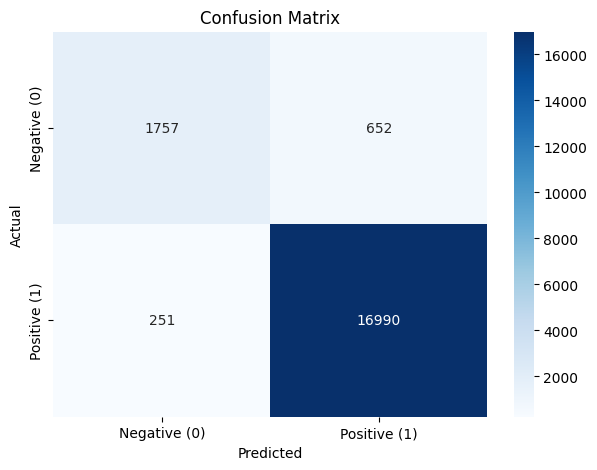


Final Model ROC AUC Score: 0.9353


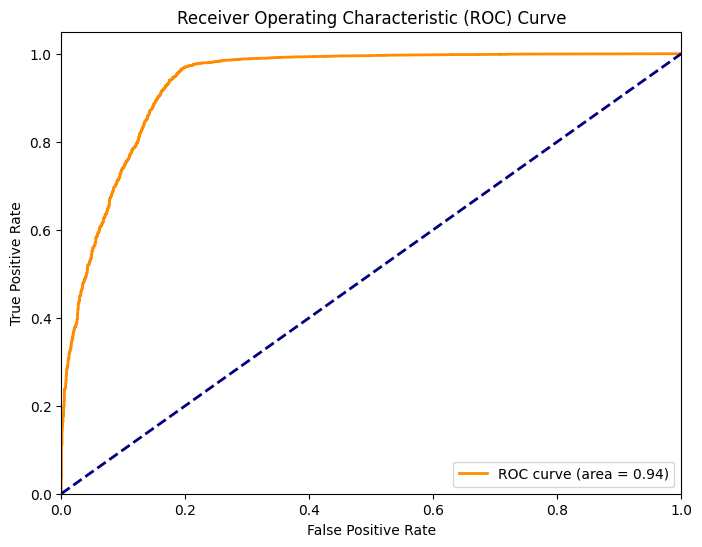

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# 1. Instantiate the best model with its best parameters
if best_model_name == 'LightGBM':
    final_model = lgb.LGBMClassifier(random_state=42, **best_params)
elif best_model_name == 'XGBoost':
    final_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False, **best_params)
else: # This will handle 'LogisticRegression'
    final_model = LogisticRegression(random_state=42, **best_params)
    
# 2. Create the final pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_model)
])

# 3. Train the final pipeline
final_pipeline.fit(X_train, y_train)

# 4. Make predictions
y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

# --- Evaluation Metrics ---

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"\nFinal Model ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Validating the model's performance in the mid-range score

As was discussed before, since mid-range scores are inherently ambiguous, representing anything from a neutral to a mildly positive or mildly negative experience, we need an alternative metric to establish the ground truth. The most reliable option is to leverage the review text itself.

Although the text review column is also a feature the model uses for prediction, the subset of the dataset with mid-range scores was previously set aside as a holdout set and excluded from training. Since the model has not been exposed to this information, we minimize the risk of introducing bias while ensuring a fair evaluation. This provides a strong approach for assessing the model’s consistency in handling score-3 reviews without jeopardizing the training process with potentially noisy examples

#### Implementation via Cosine Similarity

To generate labels from the text column in a fast, precise, and scalable manner, we will use sentence embeddings and classify each review’s sentiment by measuring its cosine similarity with curated positive and negative reference texts.

1.  **Generate Embeddings:** The `SentenceTransformer` model converts the review texts into numerical vectors using the pre-trained embedding model `paraphrase-multilingual-MiniLM-L12-v2`.
2.  **Compare to References:** Each review's embedding is compared against two pre-defined lists of embeddings: `positive_refs` (containing phrases like "Produto excelente") and `negative_refs` (containing phrases like "Veio danificado").
3.  **Classify Sentiment:** We calculate the **cosine similarity** between the review and every phrase in the reference lists. The review is assigned the sentiment of the reference phrase that yields the highest similarity score. For instance, if a review is most similar to "Entrega rápida," it is labeled as positive (1).

In [35]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

In [36]:
# Code takes up to 40 seconds to run

# Load model globally
_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

def get_embeddings(texts):
    """
    Generate embeddings for a list of texts.
    """
    return _model.encode(texts, convert_to_numpy=True)

# Reference texts
positive_refs = [
    "Chegou no dia correto", "Entrega dentro do prazo", "Produto excelente", "Bom produto",
    "Produto de qualidade", "Recomendo", "Muito satisfeito", "Produto conforme descrito",
    "Entrega rápida", "Funcionou perfeitamente", "Gostei do produto", "Produto chegou intacto",
    "Atendimento ótimo", "Produto superou minhas expectativas", "Compra tranquila", "Tudo certo com a entrega",
    "Produto confiável", "Excelente experiência de compra", "Produto bem embalado", "Ótima qualidade", "compraria novamente",

]

negative_refs = [
    "Veio danificado", "Produto quebrado", "Péssimo produto", "Não recomendo", "Achei o produto muito caro",
    "Produto ruim", "Atrasou muito", "Entrega atrasada", "Produto diferente da descrição",
    "Não funcionou", "Muito insatisfeito", "Produto veio incompleto", "Produto chegou com defeito",
    "Atendimento ruim", "Produto de baixa qualidade", "Entrega errada", "Produto chegou atrasado",
    "Decepcionante", "Compra frustrante", "Produto inutilizável", "Não valeu o preço", "Sem opinião",
    "Produto não chegou", "Não era o que eu esperava", "No site parecia melhor", "No site parecia diferente", "Deixou a desejar"
]


# Precompute embeddings for references
positive_embs = get_embeddings(positive_refs)
negative_embs = get_embeddings(negative_refs)

def classify_texts_top1_cosine(texts):
    """
    Classify texts as positive (1) or negative (0) based on top-1
    cosine similarity with reference embeddings.
    """
    text_embs = get_embeddings(texts)

    # Compute cosine similarity matrices
    pos_sims = cosine_similarity(text_embs, positive_embs)
    neg_sims = cosine_similarity(text_embs, negative_embs)

    # Take top-1 similarity for each text
    pos_top1 = np.max(pos_sims, axis=1)
    neg_top1 = np.max(neg_sims, axis=1)

    # Classify based on which top-1 similarity is higher
    return (pos_top1 > neg_top1).astype(int)

# Example: classify neutral texts
neutral_texts = holdout_reviews['combined_text'].values
pred_labels = classify_texts_top1_cosine(neutral_texts)

# Results dataframe
similarity_results = pd.DataFrame({
    'text': neutral_texts,
    'predicted_sentiment': pred_labels
})

review_score.loc[holdout_reviews_index, 'review_score'] = pred_labels

print("Sentiment distribution:", pd.Series(pred_labels).value_counts())


Sentiment distribution: 0    2298
1    1947
Name: count, dtype: int64


As anticipated, determining whether a review is positive or negative based on a mid-range score is challenging, since these cases are highly inconsistent, with nearly a 50-50 split between positive and negative reviews. Because of this, the model may struggle when predicting such examples.

Below are some examples of classifications based on cosine similarity, which seem to be quite accurate

In [37]:
similarity_results.head(30)

,text,predicted_sentiment
0,"Entrega muito demorada, apesar de não me atentar a isso quando fiz a compra, o prazo era de 30dias e mesmo assim ainda atrasou uma semana. A intenção era presentear minha filha no dia 12/10, não 01/11",0
1,dentro do anunciado.,1
2,"Preço muito bom, porém o prazo de entrega é muito extenso.",1
3,"Preço muito bom, porém o prazo de entrega é muito extenso.",1
4,Achei um pouco demorado a entrega,0
5,"Demorou para chegar mas, veio em ordem. Recomendo o vendedor mas , não tem pressa em receber.",0
6,É bem bonita e bem acabada mais pena q veio a almofadinha d uma cor e a casinha de outra 😢\r\nPor esse motivo nao vou enche de estrelas 😭,1
7,produto muito ruim não recomendo,0
8,"Chegou até antes do dia , gostei do produto e recomendo,espero que dure na mão da minha filha kkk",1
9,Recebi o produto dentro do prazo,1


Using the trained model to predict the holdout set we can see that we still have some relative good metrics 

In [38]:
# Applying lemmatization in the holdout text
holdout_reviews["combined_text"] = lemmatize(holdout_reviews["combined_text"])

# Predicting with the trained model
y_pred_holdout = final_pipeline.predict(holdout_reviews.drop(columns=['review_score', 'order_purchase_timestamp']))

# Classification Report
print("Classification Report:")
print(classification_report(similarity_results['predicted_sentiment'], y_pred_holdout))

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67      2298
           1       0.62      0.69      0.65      1947

    accuracy                           0.66      4245
   macro avg       0.66      0.66      0.66      4245
weighted avg       0.67      0.66      0.66      4245



c:\Users\Bruno Hime\OneDrive\Documentos\Bruno\Pessoal\codes\bravium\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Finally, training in the whole dataset

In [39]:
df_joined = pd.concat(
    [
        final_df_sorted.drop(columns=['target', 'order_purchase_timestamp']),
        holdout_reviews.drop(columns=['review_score', 'order_purchase_timestamp'])
    ],
    axis=0
)

df_joined_target = pd.concat(
    [
        final_df_sorted['target'],
        similarity_results["predicted_sentiment"]
    ],
    axis=0
)

y_pred_all_dataset = final_pipeline.predict(df_joined)

# Classification Report
print("Classification Report:")
print(classification_report(
    df_joined_target,
    y_pred_all_dataset
))


c:\Users\Bruno Hime\OneDrive\Documentos\Bruno\Pessoal\codes\bravium\venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.76      0.82     18006
         1.0       0.95      0.98      0.96     84485

    accuracy                           0.94    102491
   macro avg       0.91      0.87      0.89    102491
weighted avg       0.94      0.94      0.94    102491



### Important information

I could not have used the embedding technique to classify the texts and then trained the model together with the `final_df`, as this would introduce bias into the model. I would essentially be creating the target based on a column that is also being used for training. In the case above, I am only performing an evaluation, since the model parameters have already been defined. In any case, we still need to be cautious, but this remains a valid way to check how the model performs on mid-range scores.

# Interpreting the results with SHAP

To understand *why* our model makes a prediction, we use **SHAP** (SHapley Additive exPlanations). Based on game theory, it quantifies how much each feature contributes to a prediction. This moves us beyond a "black box" model to one that provides transparent and actionable insights for business decisions.



### Global Interpretation: The Big Picture

**Global** interpretation shows which features have the biggest impact across the *entire dataset*. It answers high-level questions like, *"Overall, what are the main drivers of customer satisfaction?"*



### Local Interpretation: Individual Cases

**Local** interpretation explains a *single prediction* in detail. This is powerful for root-cause analysis, such as:

* Investigating why a specific customer left an uncharacteristic negative review.
* Analyzing feedback for a newly launched product to understand its reception.

## Global Analysis

Calculating SHAP values...

Displaying the Formatted SHAP Plot (Beeswarm)...


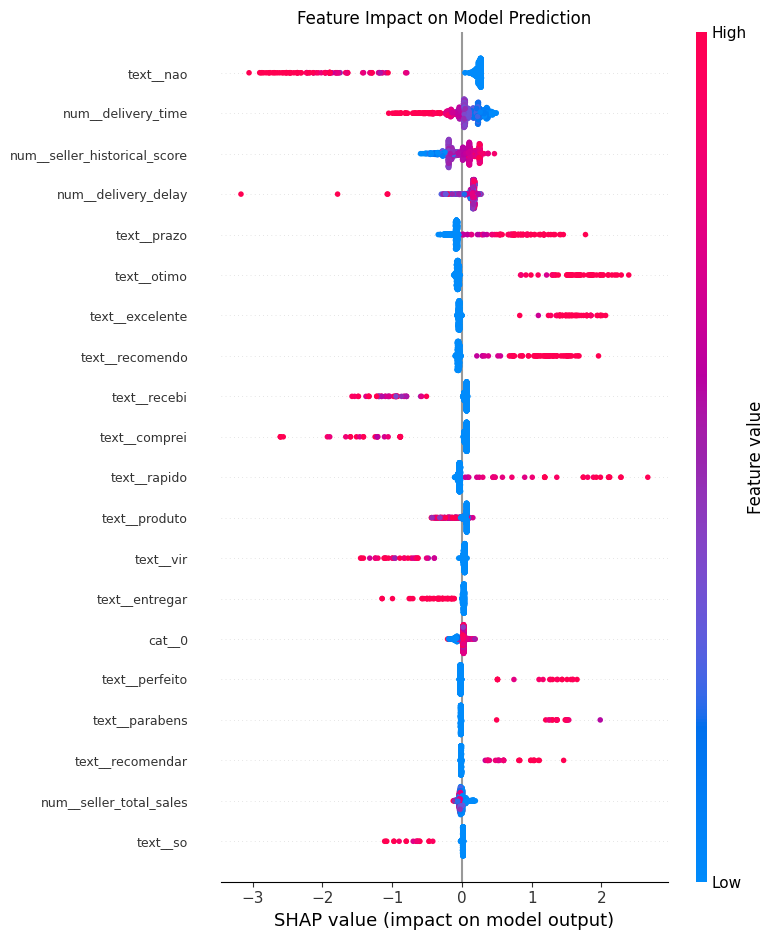

In [40]:
import shap

# Extract components from our trained pipeline
classifier = final_pipeline.named_steps['classifier']
preprocessor = final_pipeline.named_steps['preprocessor']

# Transform the test data
X_test_sample = X_test.head(1000)
X_test_sample_transformed = preprocessor.transform(X_test_sample)

# Convert to a dense array if it's a sparse matrix
if hasattr(X_test_sample_transformed, "toarray"):
    X_test_sample_transformed = X_test_sample_transformed.toarray()

# Get feature names after preprocessing
feature_names = preprocessor.get_feature_names_out()
X_test_sample_transformed_df = pd.DataFrame(X_test_sample_transformed, columns=feature_names)

# Calculate SHAP values using the modern API
print("Calculating SHAP values...")
if best_model_name in ['LightGBM', 'XGBoost']:
    explainer = shap.TreeExplainer(classifier)
elif best_model_name == 'LogisticRegression':
    explainer = shap.LinearExplainer(classifier, X_test_sample_transformed_df, feature_perturbation="interventional")
else:
    # Generic fallback for other model types
    explainer = shap.KernelExplainer(classifier.predict_proba, X_test_sample_transformed_df)

# Get the SHAP explanation object
shap_explanation_obj = explainer(X_test_sample_transformed_df)
shap_values = shap_explanation_obj.values

# Generate the SHAP Plot with Custom Formatting
print("\nDisplaying the Formatted SHAP Plot (Beeswarm)...")

# Set the title for the plot
plt.title("Feature Impact on Model Prediction")

# Create the summary plot
shap.summary_plot(shap_values, X_test_sample_transformed_df, max_display=20, show=False)

# Customize plot aesthetics
ax = plt.gca()
font_size = 9
ax.tick_params(axis='y', labelsize=font_size)
plt.tight_layout()
plt.show()

#### Understanding the Model's Decisions

The vertical axis lists the **features in order of importance**, meaning the ones at the top are those that most strongly affect the model’s decisions. Each point on the graph represents a review, and its position on the horizontal axis shows how much that specific feature influenced the prediction. Points on the **right indicate a push towards a positive review**, while points on the **left signal a negative review**. The color adds a third dimension: **red represents higher values** of the feature (for instance, longer delivery times or the presence of words like *ótimo*), while **blue represents lower values** (such as shorter delivery times or the absence of those words).


#### Key Insights from the Model

One of the clearest findings is the **strong role of positive language**. Words such as *rápido*, *recomendo*, *excelente* and *ótimo* appear consistently on the **positive side of the graph**.  

On the other hand, the model also captures **powerful negative signals**. The single word *não* is the **strongest predictor of dissatisfaction**, and its presence almost always pushes the prediction to the **negative side**.

Beyond text, **delivery time is one of the most important non-text features**: **longer delivery times** contribute to **negative predictions**, while **shorter times** are strongly associated with **positive ones**. This confirms that **logistics and punctuality** are central to customer satisfaction.  

Finally, **seller reputation emerges as a decisive factor**. Customers who buy from sellers with a **strong historical score** are much more likely to leave **positive reviews**, while **low-scoring sellers** are linked to **negative experiences**.  


By combining these observations, the SHAP plot highlights the **exact features that drive the model’s decisions**, making it both **interpretable and actionable**, and offering **clear insights** that can guide improvements in customer experience.


#### Most important words

We can also create a comparison between the top words that contribute negatively and positively to a review

C:\Users\Bruno Hime\AppData\Local\Temp\ipykernel_31780\2814086719.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_negative['mean_shap_value_abs'] = top_20_negative['mean_shap_value'] * -1


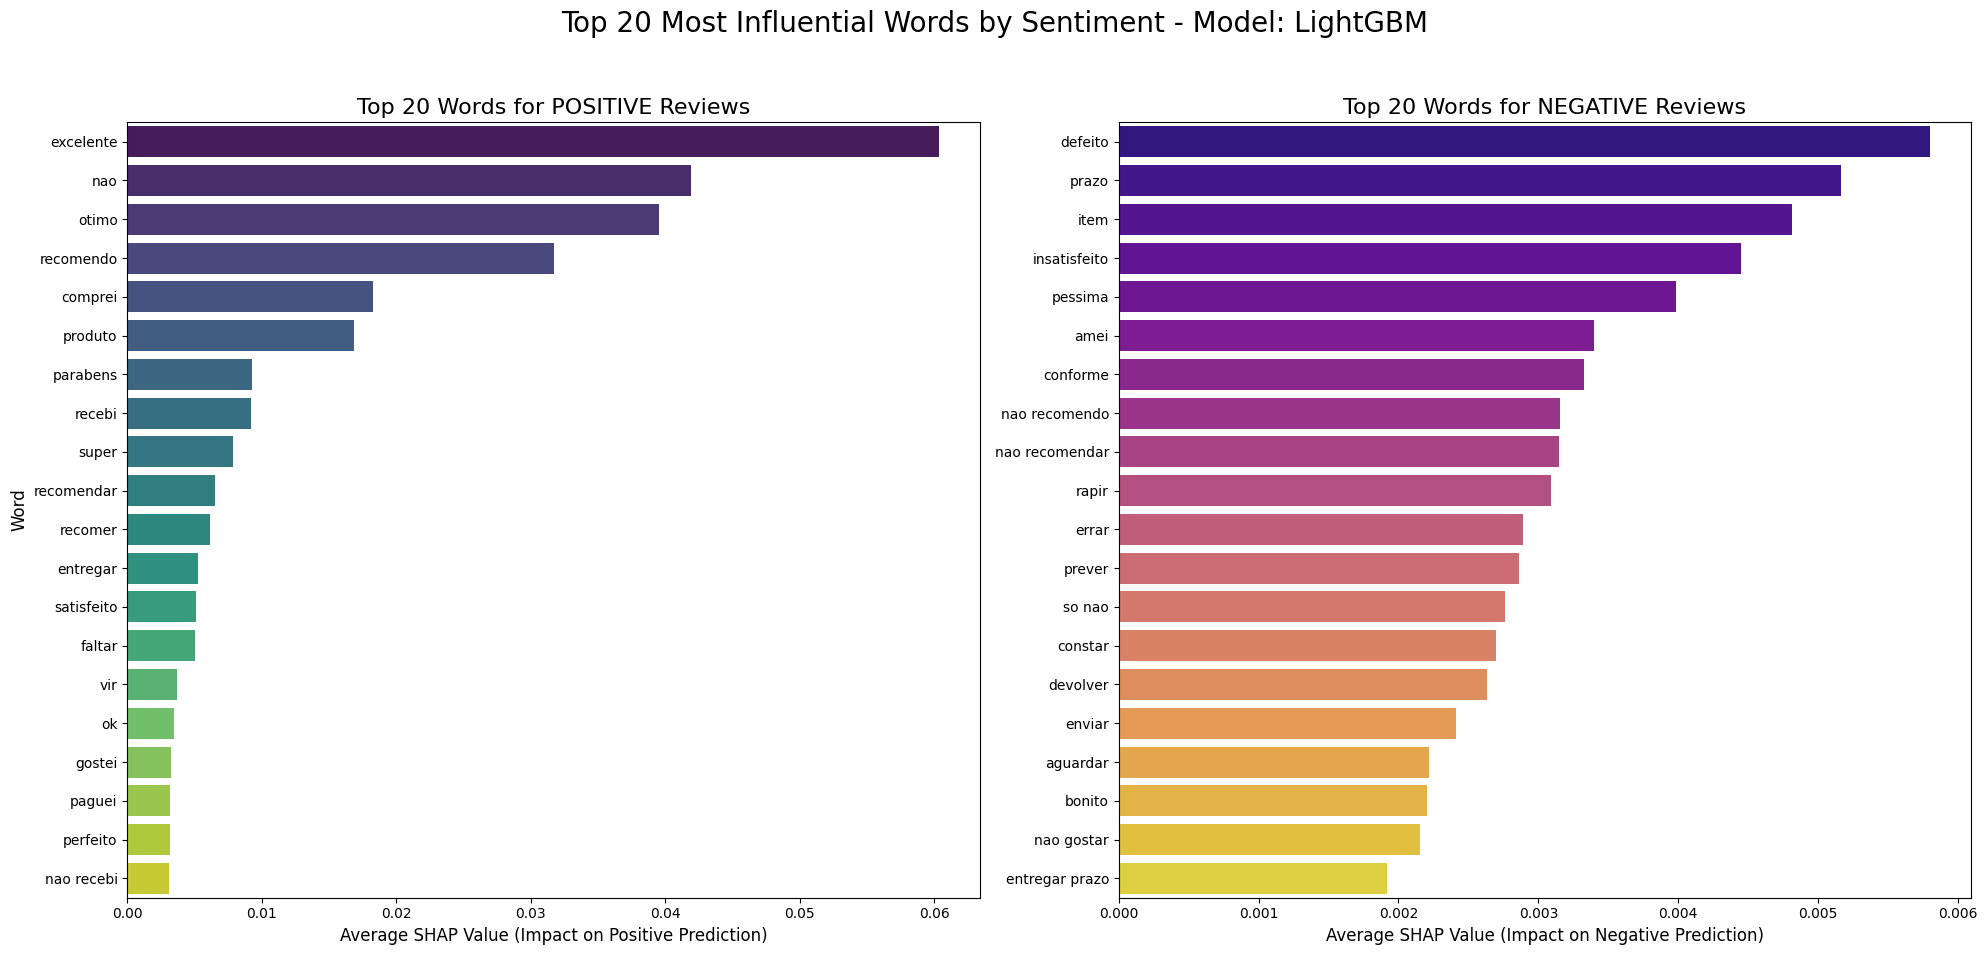

In [41]:
# This gives us a global measure of each feature's average impact and direction.
mean_shap_values = np.mean(shap_values, axis=0)

# Create a DataFrame to link feature names with their SHAP values
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_shap_value': mean_shap_values
})

# Identify words by the 'text__' prefix added by the ColumnTransformer.
word_importance_df = feature_importance_df[feature_importance_df['feature'].str.startswith('text__')].copy()
# Clean up the feature name to get just the word
word_importance_df['word'] = word_importance_df['feature'].str.replace('text__', '', regex=False)

# Get the top 20 positive and negative words
word_importance_df = word_importance_df.sort_values('mean_shap_value', ascending=False)

# Top 20 Positive Words: Highest positive mean SHAP values
top_20_positive = word_importance_df.head(20)

# Top 20 Negative Words: Most negative mean SHAP values
top_20_negative = word_importance_df.tail(20)

# Visualize the results
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'Top 20 Most Influential Words by Sentiment - Model: {best_model_name}', fontsize=20)

# Plot for Positive Words
sns.barplot(x='mean_shap_value', y='word', data=top_20_positive, ax=axes[0], palette='viridis', hue='word', legend=False)
axes[0].set_title('Top 20 Words for POSITIVE Reviews', fontsize=16)
axes[0].set_xlabel('Average SHAP Value (Impact on Positive Prediction)', fontsize=12)
axes[0].set_ylabel('Word', fontsize=12)

# Plot for Negative Words
# We multiply by -1 to make the bars positive and easier to read
top_20_negative['mean_shap_value_abs'] = top_20_negative['mean_shap_value'] * -1
sns.barplot(x='mean_shap_value_abs', y='word', data=top_20_negative.sort_values('mean_shap_value_abs', ascending=False), ax=axes[1], palette='plasma', hue='word', legend=False)
axes[1].set_title('Top 20 Words for NEGATIVE Reviews', fontsize=16)
axes[1].set_xlabel('Average SHAP Value (Impact on Negative Prediction)', fontsize=12)
axes[1].set_ylabel('') # Hide y-axis label for clarity

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Local Analysis

In this local analysis, we can understand the model’s prediction for a single example, which allows us to study one prediction in more detail.

Analyzing prediction for sample index: 10

Original feature values for this sample:


delivery_time                                                                       21.0
delivery_delay                                                                     -15.0
combined_text                 excelente \n produto de otimo qualidade , entrega rapido .
price                                                                             109.99
freight_value                                                                      23.31
product_category_name                                                      esporte_lazer
product_description_lenght                                                        3189.0
product_photos_qty                                                                   6.0
seller_historical_score                                                         4.321637
seller_total_sales                                                                 173.0
Name: 78606, dtype: object


Generating the waterfall plot...


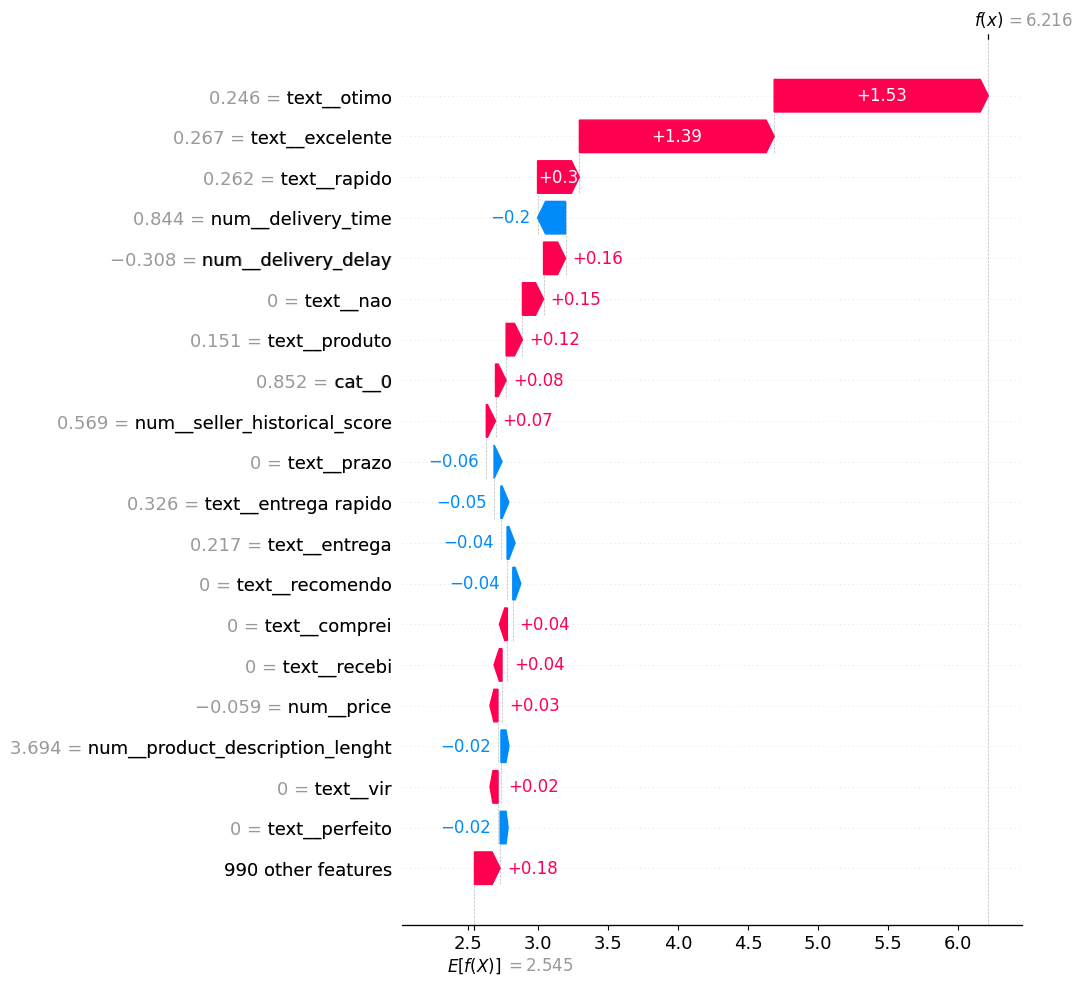

In [42]:
# Define a fixed index for the example
index_to_explain = 10
print(f"Analyzing prediction for sample index: {index_to_explain}")

# The shap_explanation_obj created can be sliced like an array
single_instance_shap = shap_explanation_obj[index_to_explain]

# Display the feature values for this sample
print("\nOriginal feature values for this sample:")
display(X_test_sample.iloc[index_to_explain])

# The waterfall_plot function only needs the SHAP object for the single instance.
# max_display limits the number of features shown to the most impactful ones.
print("\nGenerating the waterfall plot...")
shap.waterfall_plot(single_instance_shap, max_display=20, show=True)

_Example 10_

This plot shows a confident **positive** prediction, with the final score (`f(x) = 6.546`) being significantly higher than the dataset's average (`E[f(X)] = 2.584`).

The primary reason for this high score is the presence of powerful positive keywords. The words **`ótimo`** ("great") and **`excelente`** ("excellent") alone added nearly +3.0 to the score, overwhelming all other factors. This positive sentiment was further supported by an early delivery and the absence of the negative word `nao` ("not").

A slightly longer-than-average `delivery_time` provided a minor negative push, but its impact was negligible compared to the force of the positive language used in the review.